In [2]:
import fasr_solar_simul as fss
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import j1
from scipy.constants import c
import os
from casatasks import tclean, applycal, clearcal
from datetime import datetime
from pathlib import Path
from tqdm import tqdm
from astropy.time import Time
from sunpy import coordinates

# Speed of light in m/s
C_LIGHT = c
import matplotlib
%matplotlib inline

In [3]:
from importlib import reload

reload(fss)
target = 'Quiet_Sun'
figsubfolder = 'figs/'
model_dir = '../fasr_sim/skymodels/quiet_sun/'

In [4]:
# List of all available frequencies in GHz
freq_list = ['1GHz', '2GHz', '5GHz', '10GHz', '20GHz']
imsizes = [512, 512, 1024, 2048, 4096]
cells = ['4.8arcsec', '4.8arcsec', '2.4arcsec', '1.2arcsec', '0.6arcsec']
scales = [[0, 5, 10, 50], [0, 4, 10, 40], [0, 6, 20, 80], [0, 5, 10, 40, 160], [0, 10, 40, 80, 320]]

freq_init = freq_list[1]
imsize_init = imsizes[1]
cell_init = cells[1]
scale_init = scales[1]

freq_target = freq_list[2]
imsize_target = imsizes[2]
cell_target = cells[2]
scale_target = scales[2]

# List of configurations
project = 'FASR-A'
config_file = 'fasr-a_random_spiral_hybrid_120.cfg'

## Antenna temperature noise levels
tsys = 300.  # System temperature in K

## Define the fractional gain errors tuples: (phase and amplitude)
# 6 degrees (or 1.7% of phase error is equivalent to 10% of amplitude error )
#cal_errors = [(0., 0.), (0.017, 0.1)]
cal_errors = [(0.1, 0.1)]

# Define channel width and integration time
channel_width_mhz = 24. # channel width in MHz
integration_time = 1. # Time per integration in seconds
duration = 1. # Total imaging duration in seconds

# Reference timestamp for the observation series
reftime='2020-11-26T20:45:47'
solar_radius_asec = coordinates.sun.angular_radius(reftime).value

# Flags to control overwriting existing data products
overwrite_ms   = False  # Overwrite measurement set?
overwrite_im   = False  # Overwrite image products?
overwrite_plot = True  # Overwrite existing plots?

weighting = 'uniform'
# Deconvolution algorithm choice
#deconvolver = 'hogbom'
#niter = 0

deconvolver = 'multiscale'
niter = 10000

## Generate measurement sets at 2 GHz without any calibration errors

In [5]:
%matplotlib inline
reload(fss)
import time

reftime_casa = Time(reftime).strftime('%Y/%m/%d/%H:%M:%S')

figdir = os.path.join(project, figsubfolder)
if not os.path.exists(figdir):
    os.makedirs(figdir)
    
caltbdir = os.path.join(project, 'caltbs')
if not os.path.exists(caltbdir):
    os.makedirs(caltbdir)
    
cfg_suffix = os.path.basename(config_file.rstrip(".cfg"))
solar_model = f'{model_dir}/solar_disk_model_20201126.{freq_init}.masked.fits'
# Calculate theoretical sensitivity with natural weighting
antenna_params = np.genfromtxt(config_file, comments='#')
dish_diameter = antenna_params[0, 3]
uv_cell = 1. / (imsize_init * float(cell_init.rstrip('arcsec')) / 206265.)
total_flux = fss.calc_total_flux_on_dish(solar_model, dish_diameter=dish_diameter, freqghz=freq_init)
tant = fss.total_flux_to_tant(total_flux, eta_a=0.6, dish_diameter=dish_diameter)
print(f'Tant: {tant:.0f}K')
noisejy, sigma_na, sigma_un = fss.calc_noise(tsys, config_file, dish_diameter=dish_diameter, 
                                             total_flux=total_flux, duration=duration,
                                             integration_time=integration_time, 
                                             channel_width_mhz=channel_width_mhz, 
                                             freqghz=freq_init, uv_cell=uv_cell)
sigma_jy = sigma_un / np.sqrt((duration / integration_time))
    
for phaerr, amperr in cal_errors:
    phaerr_deg = np.rad2deg(phaerr)
    gaintable = [f'caltb_FASR_corrupt_{phaerr_deg:.0f}deg.ph',
                 f'caltb_FASR_corrupt_{np.int_(amperr * 100)}pct.amp']
    msname_init = fss.make_msname(project, target, freq_init, Time(reftime).datetime, duration, integration_time, config_file, tsys)
    imname_init = fss.make_imname(msname_init, deconvolver, phaerr, amperr)
    if niter == 0:
        imname_init = imname_init.replace(deconvolver, 'dirty')
    msfile_init = f'{msname_init}.ms'
    if os.path.exists(msfile_init):
        if overwrite_ms:
            os.system('rm -rf ' + msfile_init)
        else:
            pass
    
    if not os.path.exists(msfile_init):
        print('Start generating ms')
        msfile_init = fss.generate_ms(config_file, solar_model, reftime_casa, freq_init, integration_time=integration_time,
                        duration=duration, channel_width_mhz=channel_width_mhz, 
                        msname=msfile_init, tsys=tsys, usehourangle=True)
    else:
        print(f'Measurement set {msfile_init} already exists. Skipping MS generation.')

Total flux within primary beam used to calcuate the antenna temperature: 29.4 sfu
Tant: 113K
29.432328125
Calculate antenna temperature from total flux 29.432328125 sfu incident on the dish
Total noise temperature (K): 4.130e+02 K
Estimated SEFD: 1.156e+06 Jy
Estimated natural weighting point source sensitivity sigma_na: 1.396e+00 Jy/beam
Estimated uniform weighting point source sensitivity sigma_un: 1.847e+00 Jy/beam
Estimated noise per baseline per channel per polarization per integration: 1.669e+02 Jy for 7140 baselines
Measurement set FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_2GHz_20201126T20UT_dur1s_int1s_noise300K.ms already exists. Skipping MS generation.


In [6]:
print('msfile_init:', msfile_init)
print('imname_init:', imname_init)

msfile_init: FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_2GHz_20201126T20UT_dur1s_int1s_noise300K.ms
imname_init: FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_2GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr5.7deg_amperr10pct_multiscale


Image FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_2GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr5.7deg_amperr10pct_multiscale.image already exists. Skipping imaging.


(<Figure size 1000x700 with 2 Axes>, <WCSAxes: >)

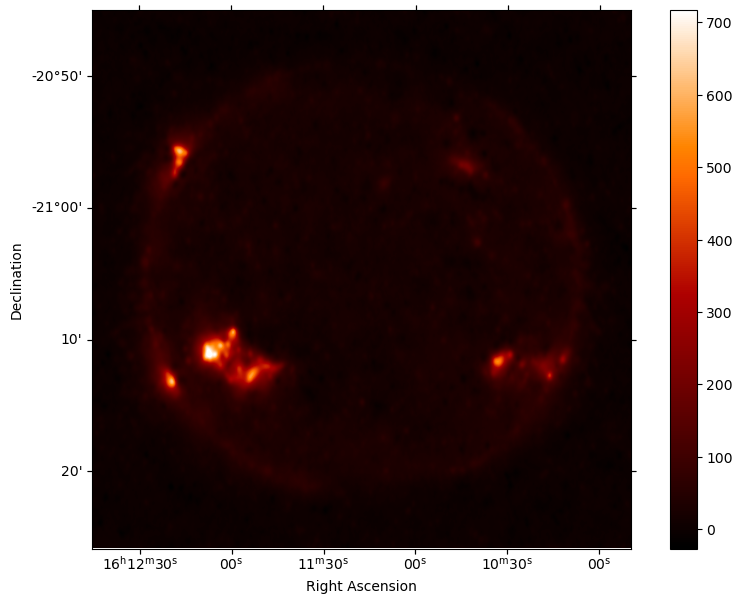

In [7]:
# now make a clean image from the generated MS without any calibration errors
reload(fss)
if not os.path.exists(f'{imname_init}.image'):
    tstart = time.time()
    if deconvolver == 'hogbom':
        tclean(vis=msfile_init, imagename=imname_init,
               datacolumn='corrected',
               field='', spw='', specmode='mfs', 
               deconvolver=deconvolver, pblimit=0.01,
               imsize=imsize, cell=cell,
               weighting=weighting,
               niter=niter,
               interactive=False)
    elif deconvolver == 'multiscale':
        tclean(vis=msfile_init, imagename=imname_init,
               datacolumn='corrected',
               field='', spw='', specmode='mfs', 
               deconvolver=deconvolver, scales=scale_init, 
               gain=0.2, cycleniter=200, minpsffraction=0.1, pblimit=0.01,
               imsize=imsize_init, cell=cell_init,
               weighting=weighting,
               niter=niter,
               interactive=False)                        
    junk = ['.model', '.mask', '.pb', '.psf', '.residual', '.sumwt']
    for j in junk:
        os.system(f'rm -rf {imname_init}{j}')
    tend = time.time()
    print(f'deconvolution completed in {(tend - tstart)/60.:.2f} minutes')
else:
    print(f'Image {imname_init}.image already exists. Skipping imaging.')

fss.plot_casa_image(imname_init + '.image', cmap='hinodexrt')

## Generate measurement sets at 5 GHz with calibration errors

In [115]:
%matplotlib inline
reload(fss)
from casatasks import split
import time
overwrite=True

# add 100% phase (of a radian) and 50% amplitude errors
cal_errors = [(3.0, 0.5)]

reftime_casa = Time(reftime).strftime('%Y/%m/%d/%H:%M:%S')

figdir = os.path.join(project, figsubfolder)
if not os.path.exists(figdir):
    os.makedirs(figdir)
    
caltbdir = os.path.join(project, 'caltbs')
if not os.path.exists(caltbdir):
    os.makedirs(caltbdir)
    
cfg_suffix = os.path.basename(config_file.rstrip(".cfg"))
solar_model = f'{model_dir}/solar_disk_model_20201126.{freq_target}.masked.fits'
# Calculate theoretical sensitivity with natural weighting
antenna_params = np.genfromtxt(config_file, comments='#')
dish_diameter = antenna_params[0, 3]
uv_cell = 1. / (imsize_target * float(cell_target.rstrip('arcsec')) / 206265.)
total_flux = fss.calc_total_flux_on_dish(solar_model, dish_diameter=dish_diameter, freqghz=freq_target)
tant = fss.total_flux_to_tant(total_flux, eta_a=0.6, dish_diameter=dish_diameter)
print(f'Tant: {tant:.0f}K')
noisejy, sigma_na, sigma_un = fss.calc_noise(tsys, config_file, dish_diameter=dish_diameter, 
                                             total_flux=total_flux, duration=duration,
                                             integration_time=integration_time, 
                                             channel_width_mhz=channel_width_mhz, 
                                             freqghz=freq_target, uv_cell=uv_cell)
sigma_jy = sigma_un / np.sqrt((duration / integration_time))
    
for phaerr, amperr in cal_errors:
    phaerr_deg = np.rad2deg(phaerr)
    gaintable = [f'caltb_FASR_corrupt_{phaerr_deg:.0f}deg.ph',
                 f'caltb_FASR_corrupt_{np.int_(amperr * 100)}pct.amp']
    msname = fss.make_msname(project, target, freq_target, Time(reftime).datetime, duration, integration_time, config_file, tsys)
    imname = fss.make_imname(msname, deconvolver, phaerr, amperr)
    if niter == 0:
        imname = imname.replace(deconvolver, 'dirty')
    msfile = f'{msname}.ms'
    if os.path.exists(msfile):
        if overwrite:
            os.system('rm -rf ' + msfile)
    
    if not os.path.exists(msfile):
        print('Start generating ms')
        msfile = fss.generate_ms(config_file, solar_model, reftime_casa, freq_target, integration_time=integration_time,
                        duration=duration, channel_width_mhz=channel_width_mhz, 
                        msname=msfile, tsys=tsys, usehourangle=True)
    else:
        print(f'Measurement set {msfile} already exists. Skipping MS generation.')
    
    if overwrite:
        os.system(f'rm -rf {caltbdir}/*')
    gaintable = fss.generate_caltb(msfile, caltype=['ph', 'amp'], 
                                   calerr=[phaerr, amperr], caltbdir=caltbdir)
    clearcal(vis=msfile)
    # Now apply calibration
    print('Applying calibration')
    applycal(vis=msfile, gaintable=gaintable, applymode='calonly', calwt=False)
    # split the ms after applying calibration

#ms_corrupted = msfile.replace('.ms', '_corrupt.ms')
ms_corrupted = msfile.replace('.ms', f'.{phaerr_deg:.0f}deg_{np.int_(amperr * 100)}pct.corrupted.ms')
if overwrite:
    os.system(f'rm -rf {ms_corrupted}')

if not os.path.exists(ms_corrupted):
    split(vis=msfile, outputvis=ms_corrupted, datacolumn='corrected')
    print('Split corrupted data into new MS:', ms_corrupted)

Total flux within primary beam used to calcuate the antenna temperature: 78.1 sfu
Tant: 300K
78.147675
Calculate antenna temperature from total flux 78.147675 sfu incident on the dish
Total noise temperature (K): 6.001e+02 K
Estimated SEFD: 1.680e+06 Jy
Estimated natural weighting point source sensitivity sigma_na: 2.029e+00 Jy/beam
Estimated uniform weighting point source sensitivity sigma_un: 2.270e+00 Jy/beam
Estimated noise per baseline per channel per polarization per integration: 2.424e+02 Jy for 7140 baselines
Start generating ms
Total flux within primary beam used to calcuate the antenna temperature: 78.1 sfu
Extracted from FITS header:
Frequency = 5GHz
Source RA = 4.238093 rad, DEC = -0.368072 rad
I am using hour angle for time specification.
Updated FASR-A/msfiles/Quiet_Sun/solar_disk_model_20201126.5GHz.masked.fits: CRVAL3 and RESTFRQ set to 5000000000.0 Hz
78.147675
Calculate antenna temperature from total flux 78.147675 sfu incident on the dish
Total noise temperature (K):

2026-02-07 19:53:06	WARN	clearcal::calibrater::setvi(bool,bool)	Forcing use of OLD VisibilityIterator.


Split corrupted data into new MS: FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_5GHz_20201126T20UT_dur1s_int1s_noise300K.172deg_50pct.corrupted.ms


Opening calibration table: FASR-A/caltbs/caltb_FASR_corrupt_172deg.ph
Shape of the data in FASR-A/caltbs/caltb_FASR_corrupt_172deg.ph: (2, 1, 120)
Number of polarizations in FASR-A/caltbs/caltb_FASR_corrupt_172deg.ph: 2


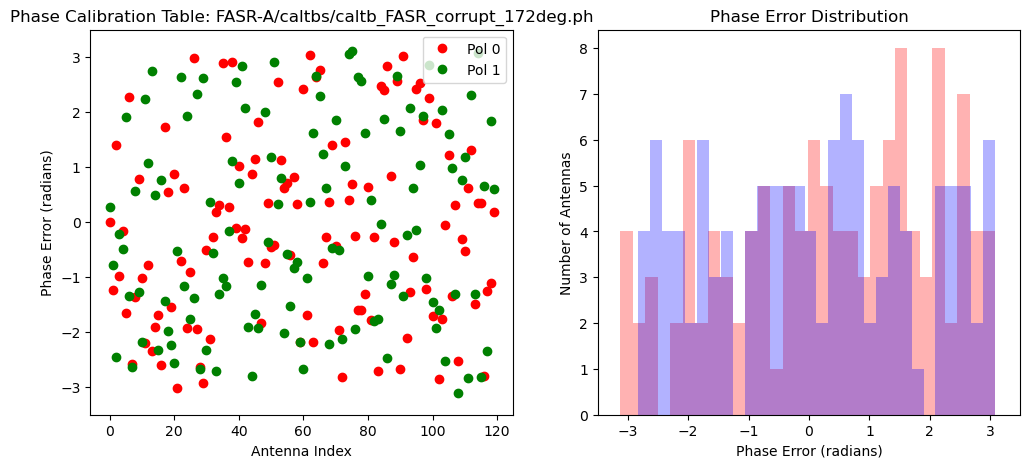

Opening calibration table: FASR-A/caltbs/caltb_FASR_corrupt_50pct.amp
Shape of the data in FASR-A/caltbs/caltb_FASR_corrupt_50pct.amp: (2, 1, 120)
Number of polarizations in FASR-A/caltbs/caltb_FASR_corrupt_50pct.amp: 2


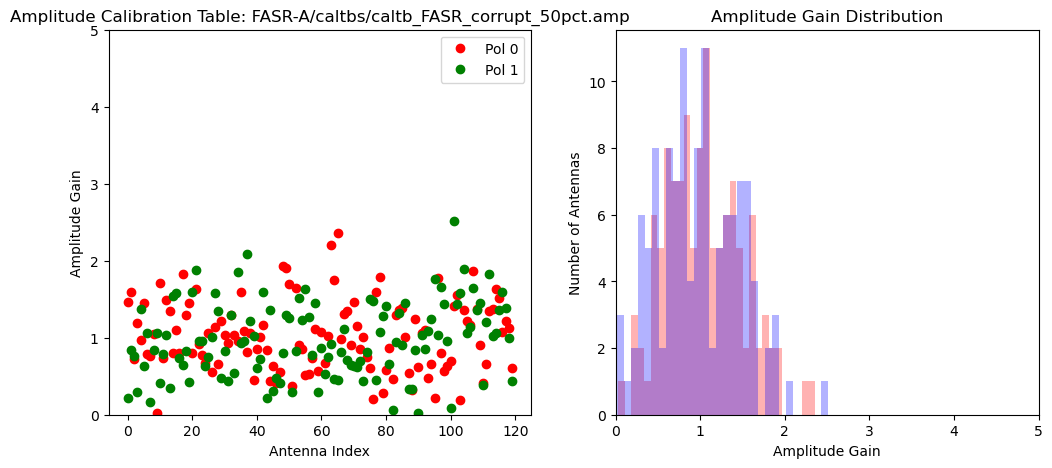

In [116]:
reload(fss)
fss.plot_caltb_stats(gaintable[0], caltype='ph', yrange=[-3.5, 3.5])
fss.plot_caltb_stats(gaintable[1], caltype='amp', yrange=[0, 5])

2026-02-07 19:54:21	WARN	SynthesisParamsImage::buildCoordinateSystem (file src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2501)	Did not get the position of FASR from data repository
2026-02-07 19:54:21	WARN	SynthesisParamsImage::buildCoordinateSystem (file src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2501)	Please contact CASA to add it to the repository.
2026-02-07 19:54:21	WARN	SynthesisParamsImage::buildCoordinateSystem (file src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2501)	Using first antenna position as refence 
2026-02-07 19:54:22	WARN	task_tclean::SIImageStore::restore (file src/code/synthesis/ImagerObjects/SIImageStore.cc, line 2247)	Restoring with an empty model image. Only residuals will be processed to form the output restored image.


Dirty image created: FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_5GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr171.9deg_amperr50pct_dirty
Removed intermediate file: FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_5GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr171.9deg_amperr50pct_dirty.model
Removed intermediate file: FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_5GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr171.9deg_amperr50pct_dirty.residual
Removed intermediate file: FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_5GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr171.9deg_amperr50pct_dirty.psf
Removed intermediate file: FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_5GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr171.9deg_amperr50pct_dirty.pb
Removed intermediate file: FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_5GHz_20201126T20UT_d

(<Figure size 1000x700 with 2 Axes>, <WCSAxes: >)

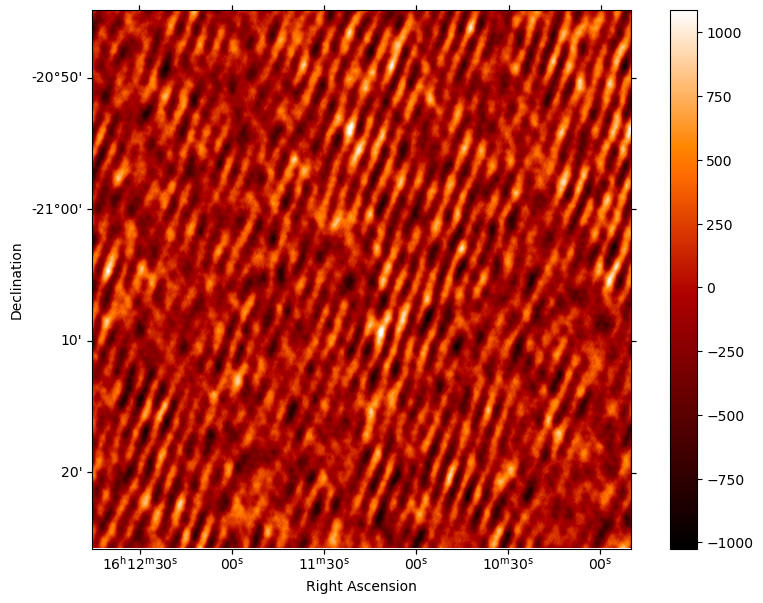

In [119]:
# Make a dirty image from the corrupted MS
imname_dirty = imname.replace(deconvolver, 'dirty')
os.system(f'rm -rf {imname_dirty}.*')
if not os.path.exists(f'{imname_dirty}.image'):
    tclean(vis=ms_corrupted,
           imagename=imname_dirty,
           imsize=imsize_target,
           cell=cell_target,
           weighting=weighting,
           deconvolver='hogbom',
           niter=0,
           interactive=False,
           savemodel='none')
    print('Dirty image created:', imname_dirty)
    # clean up intermediate files
    for suffix in ['.model', '.residual', '.psf', '.flux',
                     '.mask', '.pb', '.image.pbcor', '.sumwt']:
          file_to_remove = f'{imname_dirty}{suffix}'
          if os.path.exists(file_to_remove):
                os.system(f'rm -rf {file_to_remove}')
                print('Removed intermediate file:', file_to_remove)
fss.plot_casa_image(imname_dirty + '.image', cmap='hinodexrt')

In [120]:
# Now supply the inital image from the 2 GHz as the model image for self-calibration
imname_init_model = imname_init + '.image'
# Make a copy of the corrupted MS to perform self-calibration
ms_selfcal = ms_corrupted.replace('.ms', '_selfcal.ms')
if os.path.exists(ms_selfcal):
    os.system(f'rm -rf {ms_selfcal}')
os.system(f'cp -r {ms_corrupted} {ms_selfcal}')
print('Created copy of MS for self-calibration:', ms_selfcal)

# Modify the model image to have the same freq as the target ms visibility
# first make a copy of the initial model image
command = f"cp -r {imname_init_model} {imname_init_model.replace('.image', f'_{freq_target}model.image')}"
os.system(command)
imname_init_model = imname_init_model.replace('.image', f'_{freq_target}model.image')

# Get frequency information from the target MS
from casatools import msmetadata
msmd = msmetadata()
msmd.open(ms_selfcal)
new_freq_hz = msmd.reffreq(0)['m0']['value']
msmd.done()

# Now change the frequency axis of the model image to match the target frequency
from casatools import image
ia = image()
ia.open(imname_init_model)
csys = ia.coordsys()

# Get current reference values
refval = csys.referencevalue()['numeric']
# Update the frequency axis (index 3) to the new frequency
refval[3] = new_freq_hz

# KEY STEP: You must use setreferencevalue to update the csys object
csys.setreferencevalue(refval)

# Save the updated coordinate system to the image
ia.setcoordsys(csys.torecord())
ia.done()
print(f'Updated model image frequency to {new_freq_hz/1e9:.3f} GHz in {imname_init_model}')


Created copy of MS for self-calibration: FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_5GHz_20201126T20UT_dur1s_int1s_noise300K.172deg_50pct.corrupted_selfcal.ms
Updated model image frequency to 5.000 GHz in FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_2GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr5.7deg_amperr10pct_multiscale_5GHzmodel.image


In [121]:
# Do initial self-calibration based on input model image
from casatasks import ft, gaincal, clearcal
print(f'Initial self-calibration on {ms_selfcal}')
clearcal(vis=ms_selfcal)
ft(vis=ms_selfcal, spw='0', model=imname_init_model, usescratch=True)

uvrange = '<10klambda'
caltable_init_p = os.path.join(caltbdir, f'selfcal_init.p')
caltable_init_a = os.path.join(caltbdir, f'selfcal_init.a')
if os.path.exists(caltable_init_p):
    os.system(f'rm -rf {caltable_init_p}')
if os.path.exists(caltable_init_a):
    os.system(f'rm -rf {caltable_init_a}')
gaincal(vis=ms_selfcal, caltable=caltable_init_p, calmode='p', solint='inf', 
    refant='0', minsnr=3.0, minblperant=4, gaintype='G', append=False, uvrange=uvrange)
gaincal(vis=ms_selfcal, caltable=caltable_init_a, calmode='a', solint='inf', 
    refant='0', minsnr=3.0, minblperant=4, gaintype='G', gaintable=[caltable_init_p], append=False, uvrange=uvrange)


Initial self-calibration on FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_5GHz_20201126T20UT_dur1s_int1s_noise300K.172deg_50pct.corrupted_selfcal.ms


2026-02-07 19:54:32	WARN	calibrater::setvi(bool,bool)	Forcing use of OLD VisibilityIterator.


48 of 210 solutions flagged due to SNR < 3 in spw=0 at 2020/11/26/19:25:52.7
7 of 162 solutions flagged due to SNR < 3 in spw=0 at 2020/11/26/19:25:52.7


Opening calibration table: FASR-A/caltbs/selfcal_init.p
Shape of the data in FASR-A/caltbs/selfcal_init.p: (2, 1, 120)
Number of polarizations in FASR-A/caltbs/selfcal_init.p: 2


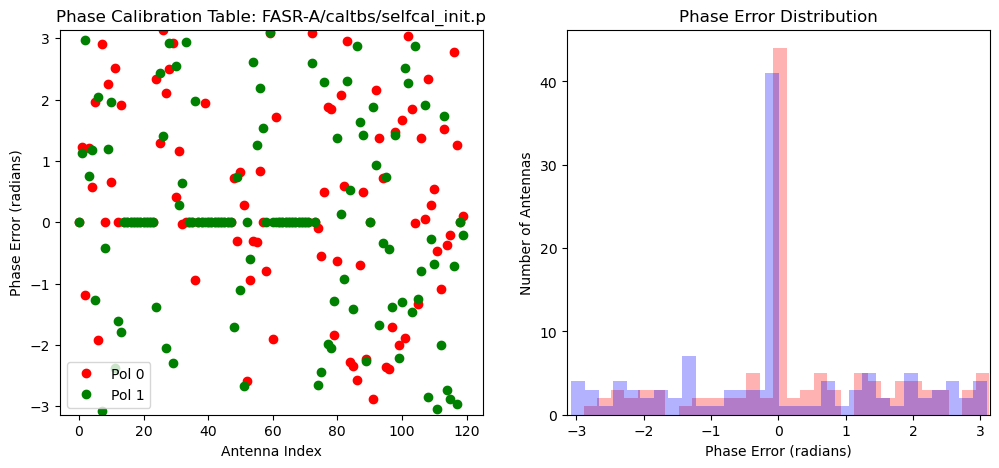

Opening calibration table: FASR-A/caltbs/caltb_FASR_corrupt_172deg.ph
Shape of the data in FASR-A/caltbs/caltb_FASR_corrupt_172deg.ph: (2, 1, 120)
Number of polarizations in FASR-A/caltbs/caltb_FASR_corrupt_172deg.ph: 2


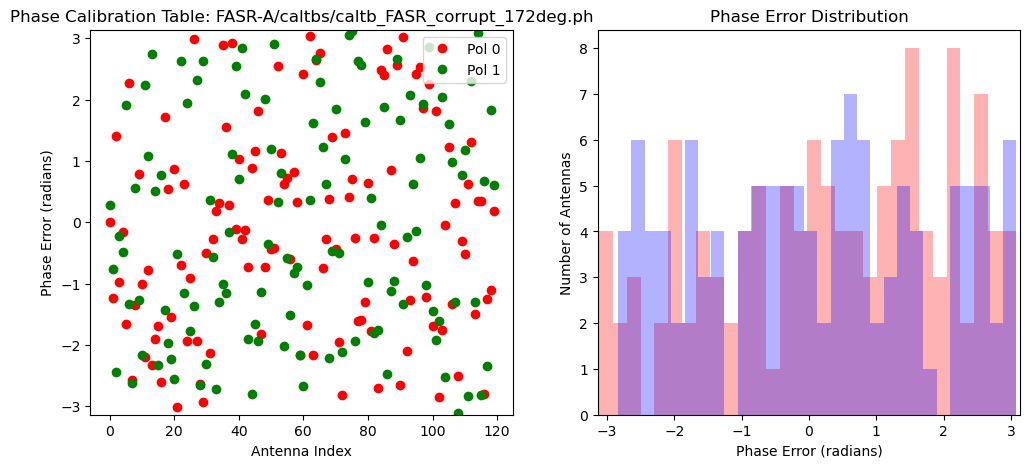

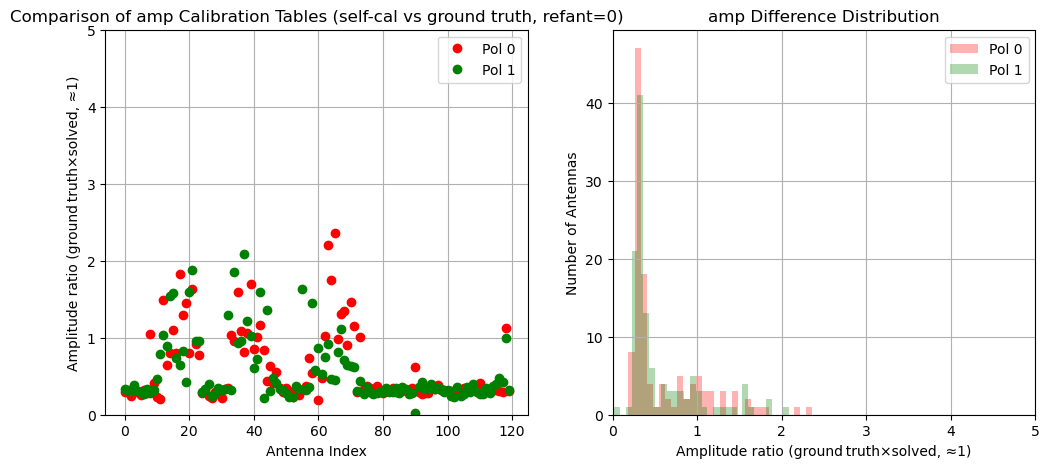

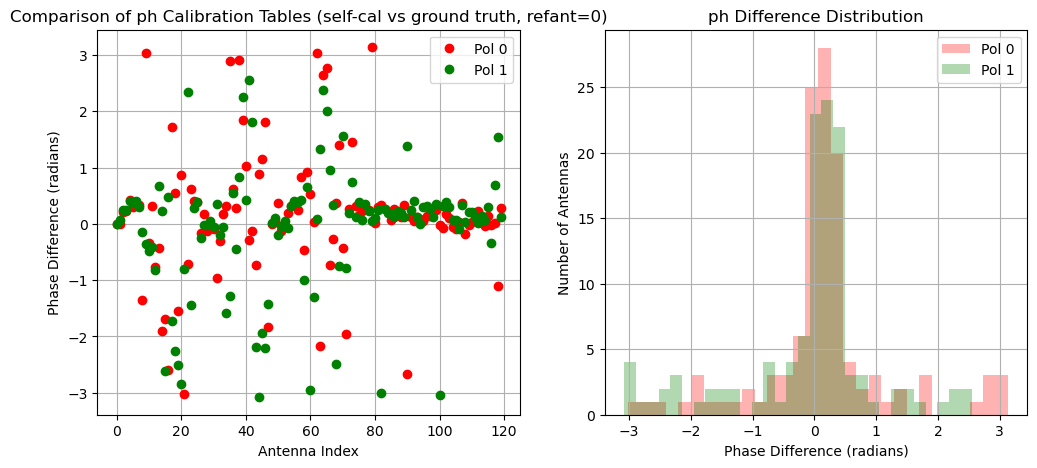

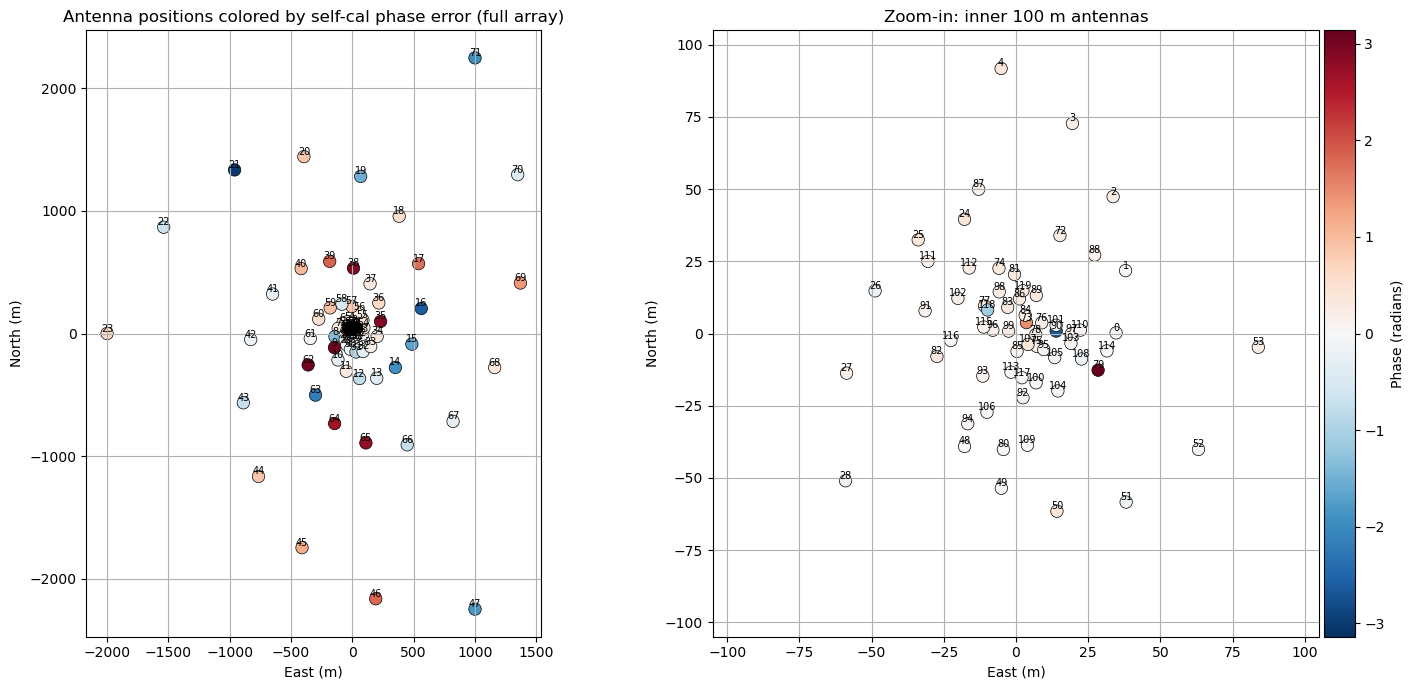

In [131]:
reload(fss)
fss.plot_caltb_stats(caltable_init_p, caltype='ph', yrange=[-3.14, 3.14], refant=0)
fss.plot_caltb_stats(gaintable[0], caltype='ph', yrange=[-3.14, 3.14], refant=0)
fss.compare_two_gaintables(gaintable[1], caltable_init_a, caltype='amp', refant='0', invert_second=True, yrange=[0, 5])
fss.plot_antenna_phase_map(config_file, caltable_init_p, ground_truth_caltb=gaintable[0], refant='0', invert_second=True)

In [123]:
# Set all FLAG values to 0 (unflag) in the calibration tables using CASA table tool
# CASA uses putcol with an array of the correct shape, not setcol with a scalar
from casatools import table
tb = table()
for cal in [caltable_init_p, caltable_init_a]:
    tb.open(cal, nomodify=False)
    flag = tb.getcol('FLAG')
    tb.putcol('FLAG', np.zeros_like(flag))
    tb.close()
print('Unflagged both', caltable_init_p, 'and', caltable_init_a)

Unflagged both FASR-A/caltbs/selfcal_init.p and FASR-A/caltbs/selfcal_init.a


2026-02-07 20:18:20	WARN	clearcal::calibrater::setvi(bool,bool)	Forcing use of OLD VisibilityIterator.
2026-02-07 20:18:21	WARN	SynthesisParamsImage::buildCoordinateSystem (file src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2501)	Did not get the position of FASR from data repository
2026-02-07 20:18:21	WARN	SynthesisParamsImage::buildCoordinateSystem (file src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2501)	Please contact CASA to add it to the repository.
2026-02-07 20:18:21	WARN	SynthesisParamsImage::buildCoordinateSystem (file src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2501)	Using first antenna position as refence 
2026-02-07 20:18:21	WARN	task_tclean::SIImageStore::restore (file src/code/synthesis/ImagerObjects/SIImageStore.cc, line 2247)	Restoring with an empty model image. Only residuals will be processed to form the output restored image.
2026-02-07 20:18:22	WARN	SynthesisParamsImage::buildCoordinateSystem (file src/code/synth

(<Figure size 1000x700 with 2 Axes>, <WCSAxes: >)

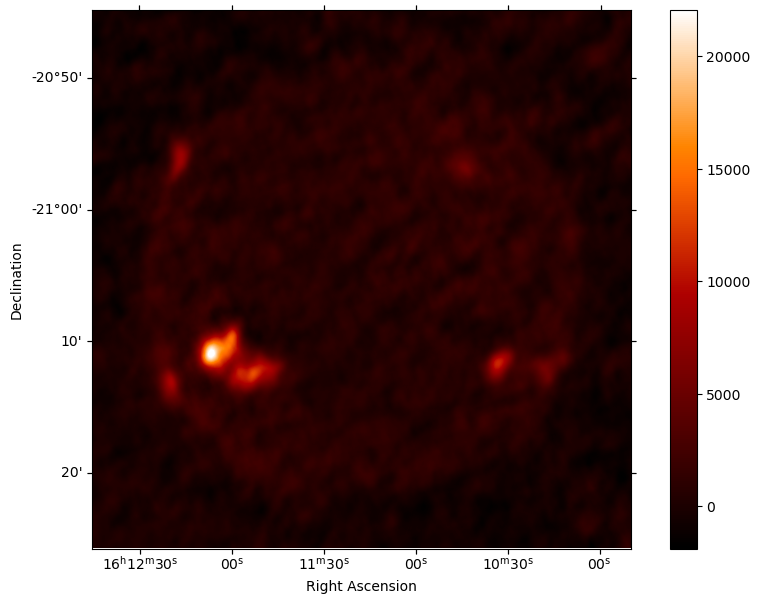

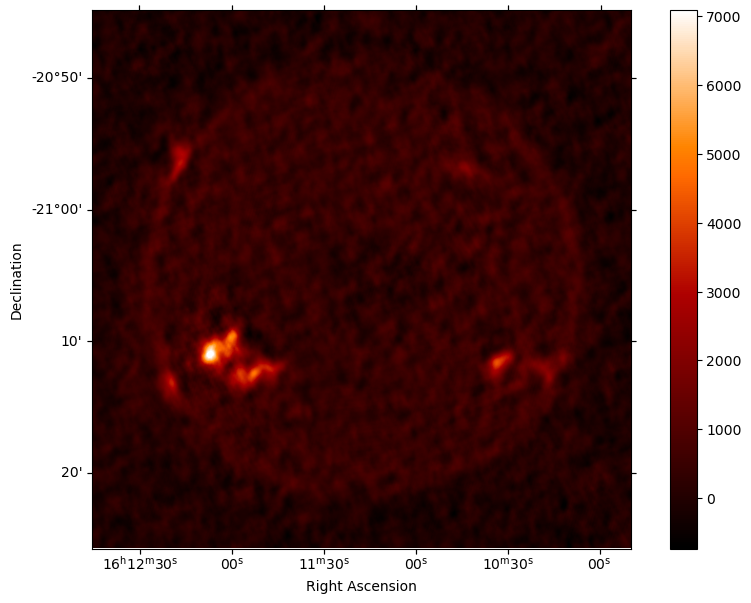

In [158]:
clearcal(vis=ms_selfcal)
applycal(vis=ms_selfcal, gaintable=[caltable_init_p, caltable_init_a], calwt=False, applymode='calonly')
imname_dirty = imname.replace(deconvolver, 'dirty')
if os.path.exists(f'{imname_dirty}.image'):
    os.system(f'rm -rf {imname_dirty}.*')
tclean(vis=ms_selfcal, imagename=imname_dirty, imsize=imsize_init, cell=cell_init,
       weighting=weighting, deconvolver='hogbom', niter=0, savemodel='none')
fss.plot_casa_image(imname_dirty + '.image', cmap='hinodexrt')

deconvolver = 'multiscale'
imname_clean = imname.replace(deconvolver, 'clean')
if os.path.exists(f'{imname_clean}.image'):
    os.system(f'rm -rf {imname_clean}.*')
tclean(vis=ms_selfcal, imagename=imname_clean, imsize=imsize_init, cell=cell_init,
       weighting=weighting, deconvolver='multiscale', 
       scales=[0, 5, 10, 40, 160], gain=0.2, cycleniter=200, minpsffraction=0.1, pblimit=0.01,
       niter=1000, savemodel='modelcolumn')
fss.plot_casa_image(imname_clean + '.image', cmap='hinodexrt')

40 of 218 solutions flagged due to SNR < 3 in spw=0 at 2020/11/26/19:25:52.7
6 of 178 solutions flagged due to SNR < 3 in spw=0 at 2020/11/26/19:25:52.7


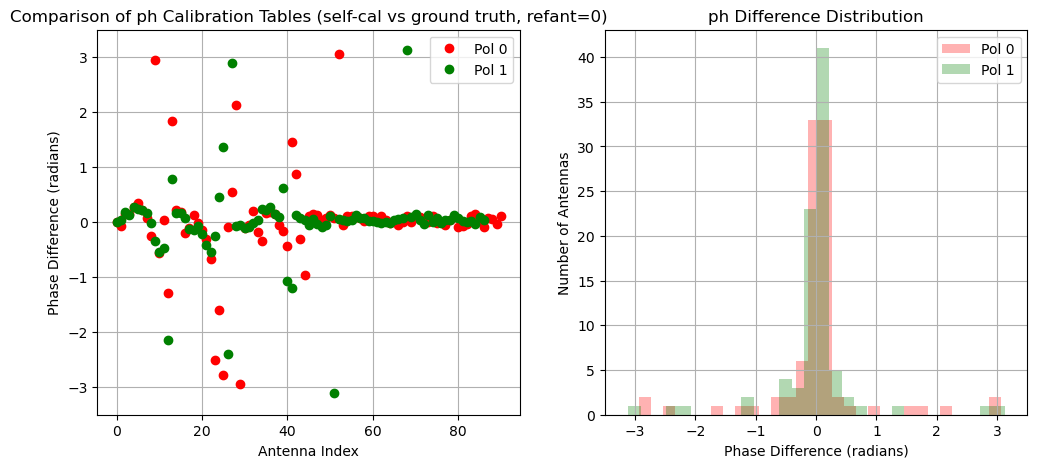

Unflagged both FASR-A/caltbs/selfcal_round1_p_comb.p and FASR-A/caltbs/selfcal_round1_a_comb.a


In [159]:
caltable_round1_p = os.path.join(caltbdir, f'selfcal_round1.p')
caltable_round1_a = os.path.join(caltbdir, f'selfcal_round1.a')
if os.path.exists(caltable_round1_p):
    os.system(f'rm -rf {caltable_round1_p}')
if os.path.exists(caltable_round1_a):
    os.system(f'rm -rf {caltable_round1_a}')
uvrange = '<12klambda'

gaincal(vis=ms_selfcal, caltable=caltable_round1_p, calmode='p', solint='inf', 
    refant='0', minsnr=3.0, minblperant=4, gaintype='G', uvrange=uvrange, gaintable=[caltable_init_p, caltable_init_a])
gaincal(vis=ms_selfcal, caltable=caltable_round1_a, calmode='a', solint='inf', 
    refant='0', minsnr=3.0, minblperant=4, gaintype='G', uvrange=uvrange, gaintable=[caltable_init_p, caltable_init_a, caltable_round1_p])

caltable_round1_p_comb = os.path.join(caltbdir, f'selfcal_round1_p_comb.p')
caltable_round1_p_comb = fss.combine_gaintables([caltable_round1_p, caltable_init_p], caltable_round1_p_comb, overwrite=True)
caltable_round1_a_comb = os.path.join(caltbdir, f'selfcal_round1_a_comb.a')
caltable_round1_a_comb = fss.combine_gaintables([caltable_round1_a, caltable_init_a], caltable_round1_a_comb, overwrite=True)
diff = fss.compare_two_gaintables(gaintable[0], caltable_round1_p_comb, caltype='ph', refant='0', invert_second=True, yrange=[-3.5, 3.5])

from casatools import table
tb = table()
for cal in [caltable_round1_p_comb, caltable_round1_a_comb]:
    tb.open(cal, nomodify=False)
    flag = tb.getcol('FLAG')
    tb.putcol('FLAG', np.zeros_like(flag))
    tb.close()
print('Unflagged both', caltable_round1_p_comb, 'and', caltable_round1_a_comb)


2026-02-07 20:19:12	WARN	clearcal::calibrater::setvi(bool,bool)	Forcing use of OLD VisibilityIterator.
2026-02-07 20:19:12	WARN	SynthesisParamsImage::buildCoordinateSystem (file src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2501)	Did not get the position of FASR from data repository
2026-02-07 20:19:12	WARN	SynthesisParamsImage::buildCoordinateSystem (file src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2501)	Please contact CASA to add it to the repository.
2026-02-07 20:19:12	WARN	SynthesisParamsImage::buildCoordinateSystem (file src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2501)	Using first antenna position as refence 
2026-02-07 20:19:13	WARN	task_tclean::SIImageStore::restore (file src/code/synthesis/ImagerObjects/SIImageStore.cc, line 2247)	Restoring with an empty model image. Only residuals will be processed to form the output restored image.
2026-02-07 20:19:13	WARN	SynthesisParamsImage::buildCoordinateSystem (file src/code/synth

(<Figure size 1000x700 with 2 Axes>, <WCSAxes: >)

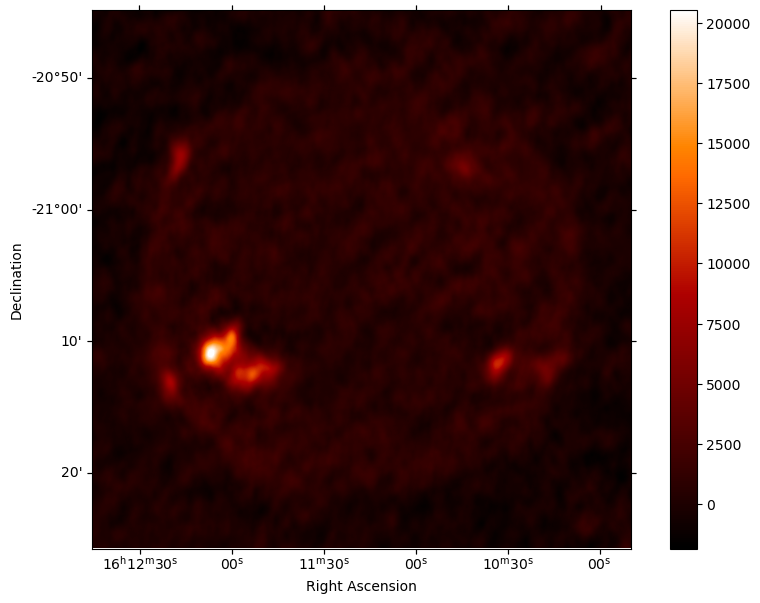

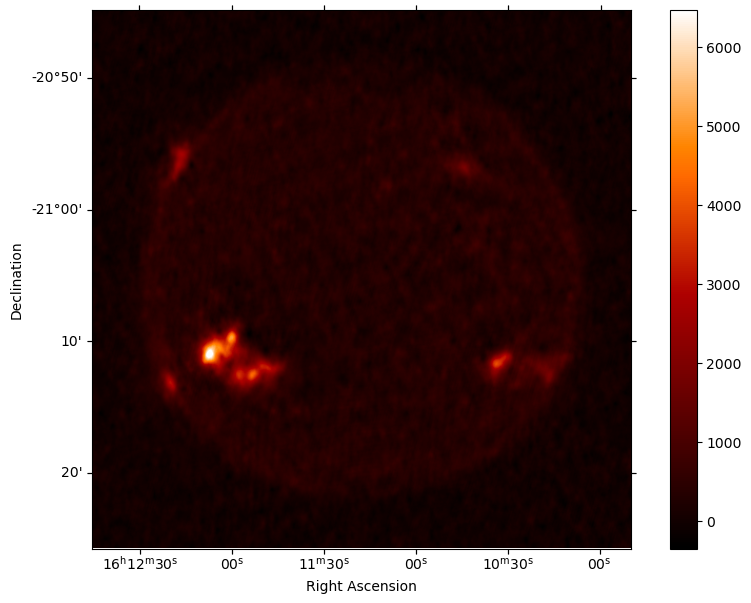

In [160]:
clearcal(vis=ms_selfcal)
applycal(vis=ms_selfcal, gaintable=[caltable_round1_p_comb, caltable_round1_a_comb], calwt=False, applymode='calonly')
imname_dirty = imname.replace(deconvolver, 'dirty')
if os.path.exists(f'{imname_dirty}.image'):
    os.system(f'rm -rf {imname_dirty}.*')
tclean(vis=ms_selfcal, imagename=imname_dirty, imsize=imsize_init, cell=cell_init,
       weighting=weighting, deconvolver='hogbom', niter=0, savemodel='none')
fss.plot_casa_image(imname_dirty + '.image', cmap='hinodexrt')

deconvolver = 'multiscale'
imname_clean = imname.replace(deconvolver, 'clean')
if os.path.exists(f'{imname_clean}.image'):
    os.system(f'rm -rf {imname_clean}.*')
tclean(vis=ms_selfcal, imagename=imname_clean, imsize=imsize_init, cell=cell_init,
       weighting=weighting, deconvolver='multiscale', 
       scales=[0, 5, 10, 40, 160], gain=0.2, cycleniter=200, minpsffraction=0.1, pblimit=0.01,
       niter=5000, savemodel='modelcolumn')
fss.plot_casa_image(imname_clean + '.image', cmap='hinodexrt')

19 of 224 solutions flagged due to SNR < 3 in spw=0 at 2020/11/26/19:25:52.7
7 of 205 solutions flagged due to SNR < 3 in spw=0 at 2020/11/26/19:25:52.7


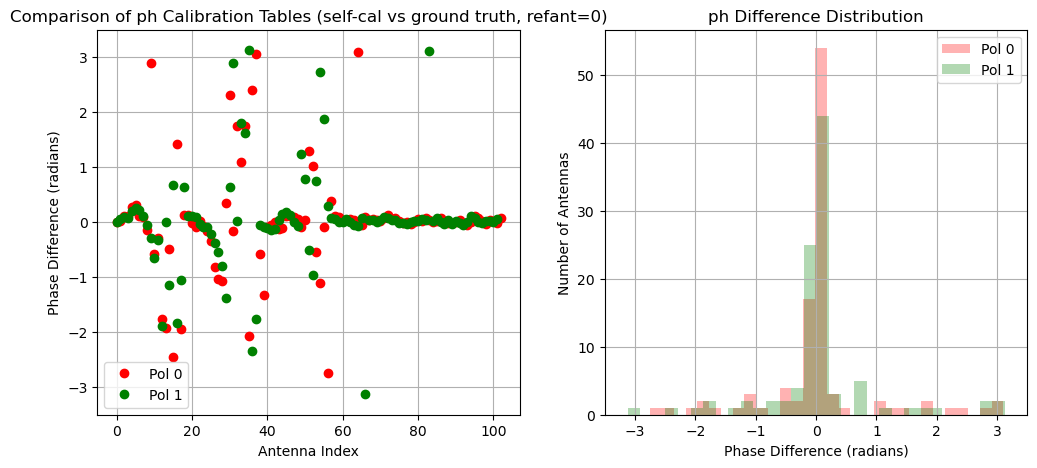

Unflagged both FASR-A/caltbs/selfcal_round2_p_comb.p and FASR-A/caltbs/selfcal_round2_a_comb.a


In [164]:
reload(fss)
caltable_round2_p = os.path.join(caltbdir, f'selfcal_round2.p')
caltable_round2_a = os.path.join(caltbdir, f'selfcal_round2.a')
if os.path.exists(caltable_round2_p):
    os.system(f'rm -rf {caltable_round2_p}')
if os.path.exists(caltable_round2_a):
    os.system(f'rm -rf {caltable_round2_a}')
uvrange = '<15klambda'

gaincal(vis=ms_selfcal, caltable=caltable_round2_p, calmode='p', solint='inf', 
    refant='0', minsnr=3.0, minblperant=4, gaintype='G', uvrange=uvrange, gaintable=[caltable_round1_p_comb, caltable_round1_a_comb])
gaincal(vis=ms_selfcal, caltable=caltable_round2_a, calmode='a', solint='inf', 
    refant='0', minsnr=3.0, minblperant=4, gaintype='G', uvrange=uvrange, gaintable=[caltable_round1_p_comb, caltable_round1_a_comb, caltable_round2_p])

caltable_round2_p_comb = os.path.join(caltbdir, f'selfcal_round2_p_comb.p')
caltable_round2_p_comb = fss.combine_gaintables([caltable_round2_p, caltable_round1_p_comb], caltable_round2_p_comb, overwrite=True)
caltable_round2_a_comb = os.path.join(caltbdir, f'selfcal_round2_a_comb.a')
caltable_round2_a_comb = fss.combine_gaintables([caltable_round2_a, caltable_round1_a_comb], caltable_round2_a_comb, overwrite=True)
diff = fss.compare_two_gaintables(gaintable[0], caltable_round2_p_comb, caltype='ph', refant='0', invert_second=True, yrange=[-3.5, 3.5])

from casatools import table
tb = table()
for cal in [caltable_round2_p_comb, caltable_round2_a_comb]:
    tb.open(cal, nomodify=False)
    flag = tb.getcol('FLAG')
    tb.putcol('FLAG', np.zeros_like(flag))
    tb.close()
print('Unflagged both', caltable_round2_p_comb, 'and', caltable_round2_a_comb)


2026-02-07 20:25:50	WARN	clearcal::calibrater::setvi(bool,bool)	Forcing use of OLD VisibilityIterator.
2026-02-07 20:25:51	WARN	SynthesisParamsImage::buildCoordinateSystem (file src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2501)	Did not get the position of FASR from data repository
2026-02-07 20:25:51	WARN	SynthesisParamsImage::buildCoordinateSystem (file src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2501)	Please contact CASA to add it to the repository.
2026-02-07 20:25:51	WARN	SynthesisParamsImage::buildCoordinateSystem (file src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2501)	Using first antenna position as refence 
2026-02-07 20:25:51	WARN	task_tclean::SIImageStore::restore (file src/code/synthesis/ImagerObjects/SIImageStore.cc, line 2247)	Restoring with an empty model image. Only residuals will be processed to form the output restored image.
2026-02-07 20:25:52	WARN	SynthesisParamsImage::buildCoordinateSystem (file src/code/synth

(<Figure size 1000x700 with 2 Axes>, <WCSAxes: >)

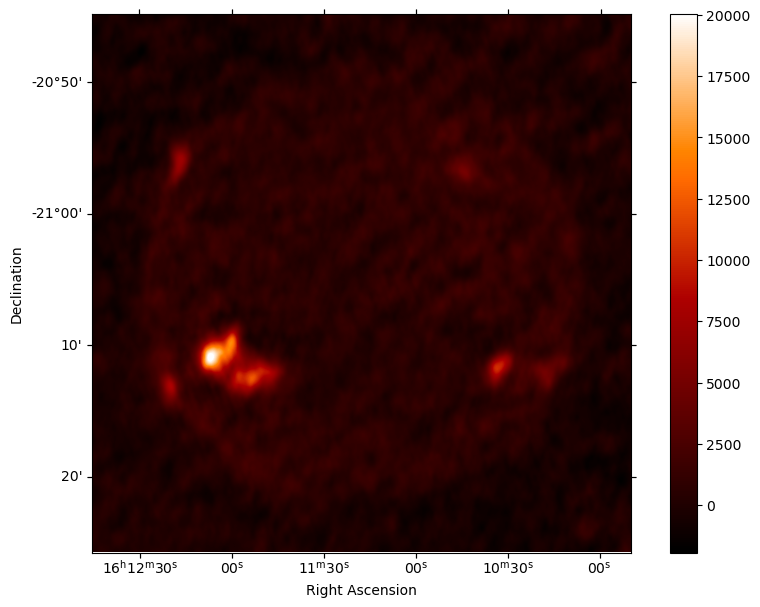

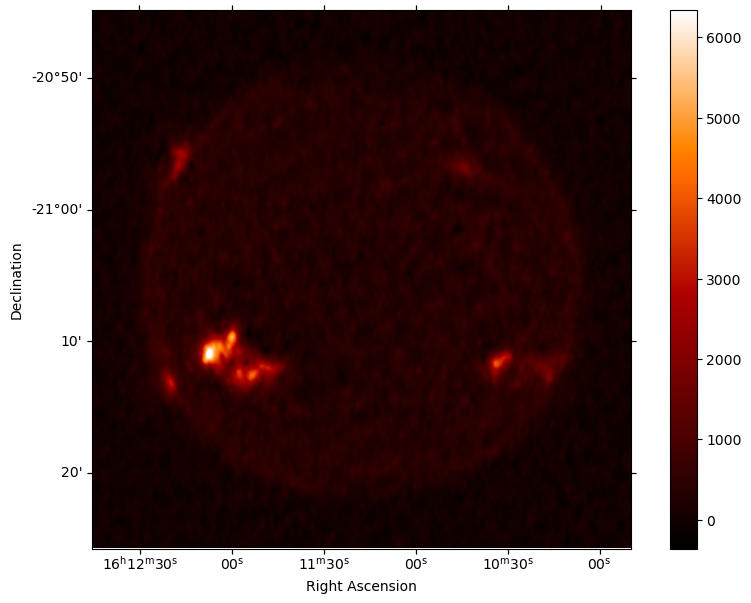

In [165]:
clearcal(vis=ms_selfcal)
applycal(vis=ms_selfcal, gaintable=[caltable_round2_p_comb, caltable_round2_a_comb], calwt=False, applymode='calonly')
imname_dirty = imname.replace(deconvolver, '.round2.dirty')
if os.path.exists(f'{imname_dirty}.image'):
    os.system(f'rm -rf {imname_dirty}.*')
tclean(vis=ms_selfcal, imagename=imname_dirty, imsize=imsize_init, cell=cell_init,
       weighting=weighting, deconvolver='hogbom', niter=0, savemodel='none')
fss.plot_casa_image(imname_dirty + '.image', cmap='hinodexrt')

deconvolver = 'multiscale'
imname_clean = imname.replace(deconvolver, '.round2.clean')
if os.path.exists(f'{imname_clean}.image'):
    os.system(f'rm -rf {imname_clean}.*')
tclean(vis=ms_selfcal, imagename=imname_clean, imsize=imsize_init, cell=cell_init,
       weighting=weighting, deconvolver='multiscale', 
       scales=[0, 5, 10, 40, 160], gain=0.2, cycleniter=200, minpsffraction=0.1, pblimit=0.01,
       niter=5000, savemodel='modelcolumn')
fss.plot_casa_image(imname_clean + '.image', cmap='hinodexrt')

20 of 224 solutions flagged due to SNR < 3 in spw=0 at 2020/11/26/19:25:52.7
4 of 204 solutions flagged due to SNR < 3 in spw=0 at 2020/11/26/19:25:52.7


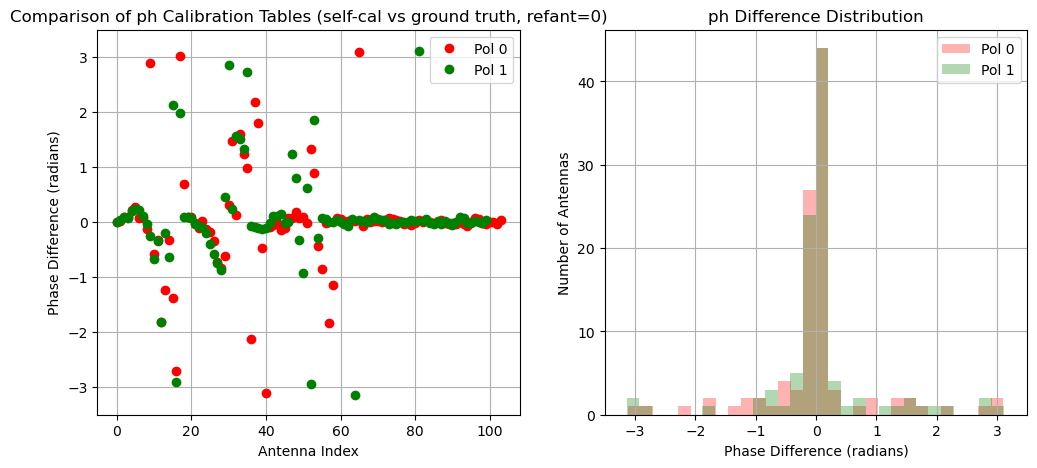

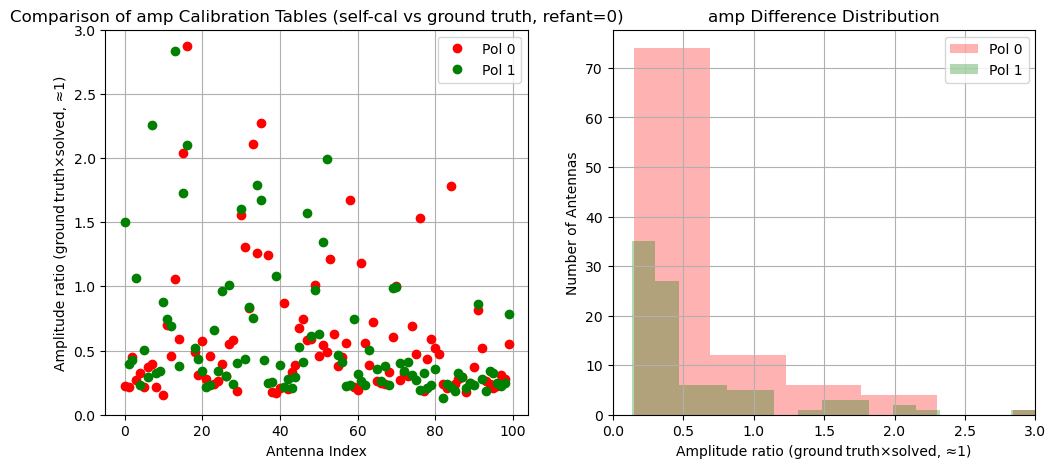

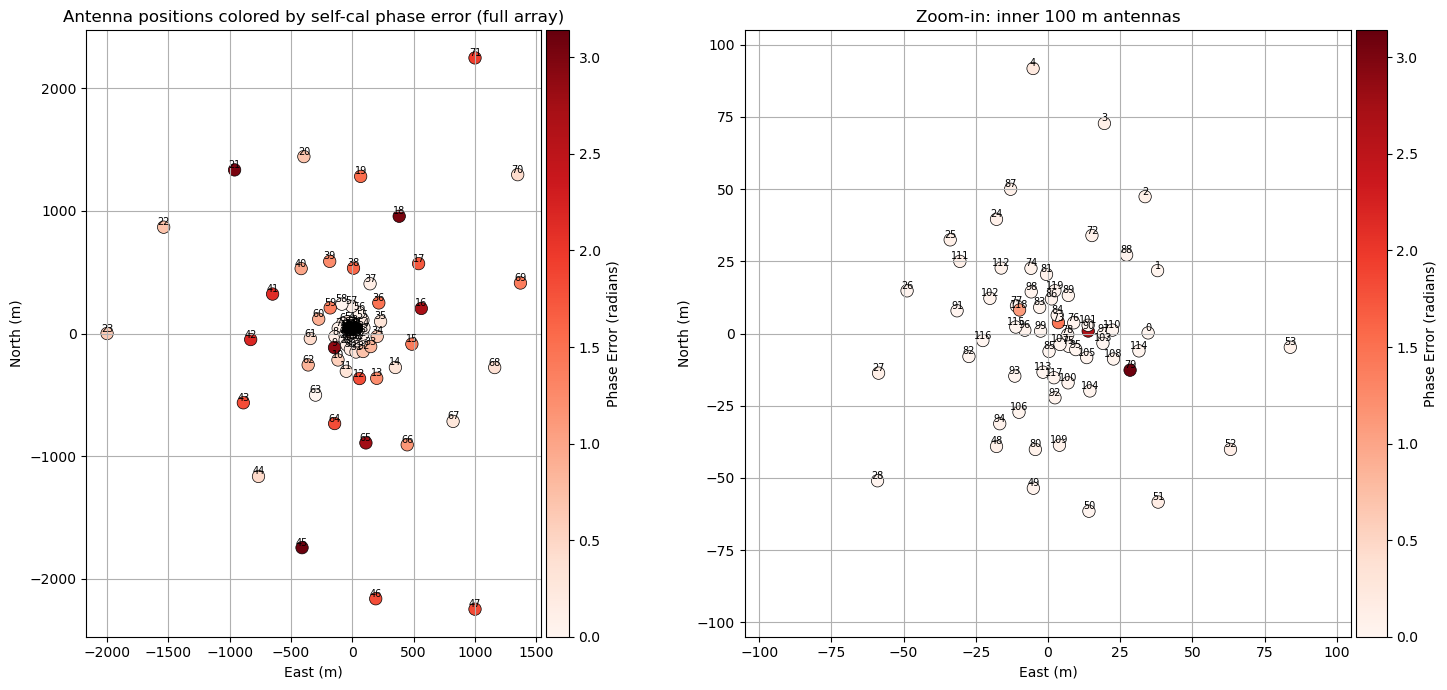

Unflagged both FASR-A/caltbs/selfcal_round3_p_comb.p and FASR-A/caltbs/selfcal_round3_a_comb.a


In [ ]:
reload(fss)
caltable_round3_p = os.path.join(caltbdir, f'selfcal_round3.p')
caltable_round3_a = os.path.join(caltbdir, f'selfcal_round3.a')
if os.path.exists(caltable_round3_p):
    os.system(f'rm -rf {caltable_round3_p}')
if os.path.exists(caltable_round3_a):
    os.system(f'rm -rf {caltable_round3_a}')
uvrange = '<15klambda'

gaincal(vis=ms_selfcal, caltable=caltable_round3_p, calmode='p', solint='inf', 
    refant='0', minsnr=3.0, minblperant=4, gaintype='G', uvrange=uvrange, gaintable=[caltable_round2_p_comb, caltable_round2_a_comb])
gaincal(vis=ms_selfcal, caltable=caltable_round3_a, calmode='a', solint='inf', 
    refant='0', minsnr=3.0, minblperant=4, gaintype='G', uvrange=uvrange, gaintable=[caltable_round2_p_comb, caltable_round2_a_comb, caltable_round3_p])

caltable_round3_p_comb = os.path.join(caltbdir, f'selfcal_round3_p_comb.p')
caltable_round3_p_comb = fss.combine_gaintables([caltable_round3_p, caltable_round2_p_comb], caltable_round3_p_comb, overwrite=True)
caltable_round3_a_comb = os.path.join(caltbdir, f'selfcal_round3_a_comb.a')
caltable_round3_a_comb = fss.combine_gaintables([caltable_round3_a, caltable_round2_a_comb], caltable_round3_a_comb, overwrite=True)
diff_ph = fss.compare_two_gaintables(gaintable[0], caltable_round3_p_comb, caltype='ph', refant='0', invert_second=True, yrange=[-3.5, 3.5])
diff_amp = fss.compare_two_gaintables(gaintable[0], caltable_round3_a_comb, caltype='amp', refant='0', invert_second=True, yrange=[0, 3])
fss.plot_antenna_phase_map(config_file, caltable_round3_p_comb, ground_truth_caltb=gaintable[0], pol=0, refant='0', invert_second=True, do_plot_diff=False)

from casatools import table
tb = table()
for cal in [caltable_round3_p_comb, caltable_round3_a_comb]:
    tb.open(cal, nomodify=False)
    flag = tb.getcol('FLAG')
    tb.putcol('FLAG', np.zeros_like(flag))
    tb.close()
print('Unflagged both', caltable_round3_p_comb, 'and', caltable_round3_a_comb)

Self-cal round 0: uvrange=<8klambda, calmode=p, niter=100
  [ft] Filling MODEL column of FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_5GHz_20201126T20UT_dur1s_int1s_noise300K.172deg_50pct.corrupted_selfcal.ms with FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_2GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr5.7deg_amperr10pct_multiscale_5GHzmodel.image
  [gaincal] Solving round 0 -> FASR-A/caltbs/selfcal_round0.p
  --- Round FASR-A/caltbs/selfcal_combined_round0.ap diagnostics (FASR-A/caltbs/selfcal_round0.p) ---
      Antennas with solutions: 59/120
      Flagged antennas (61): [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 73, 90, 118]
      RMS solved phase (Pol0/Pol1): 101.68 / 95.89 deg


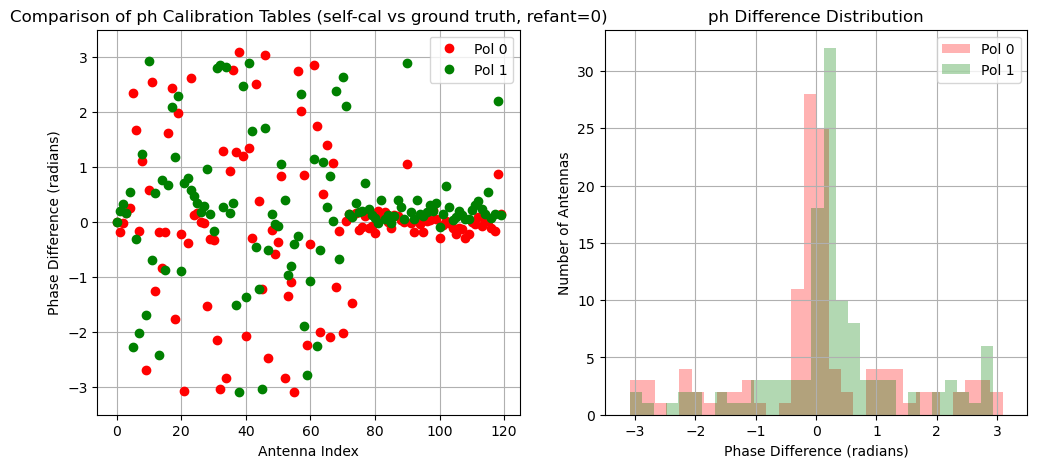

      RMS phase error vs truth (Pol0/Pol1): 9.57 / 15.22 deg


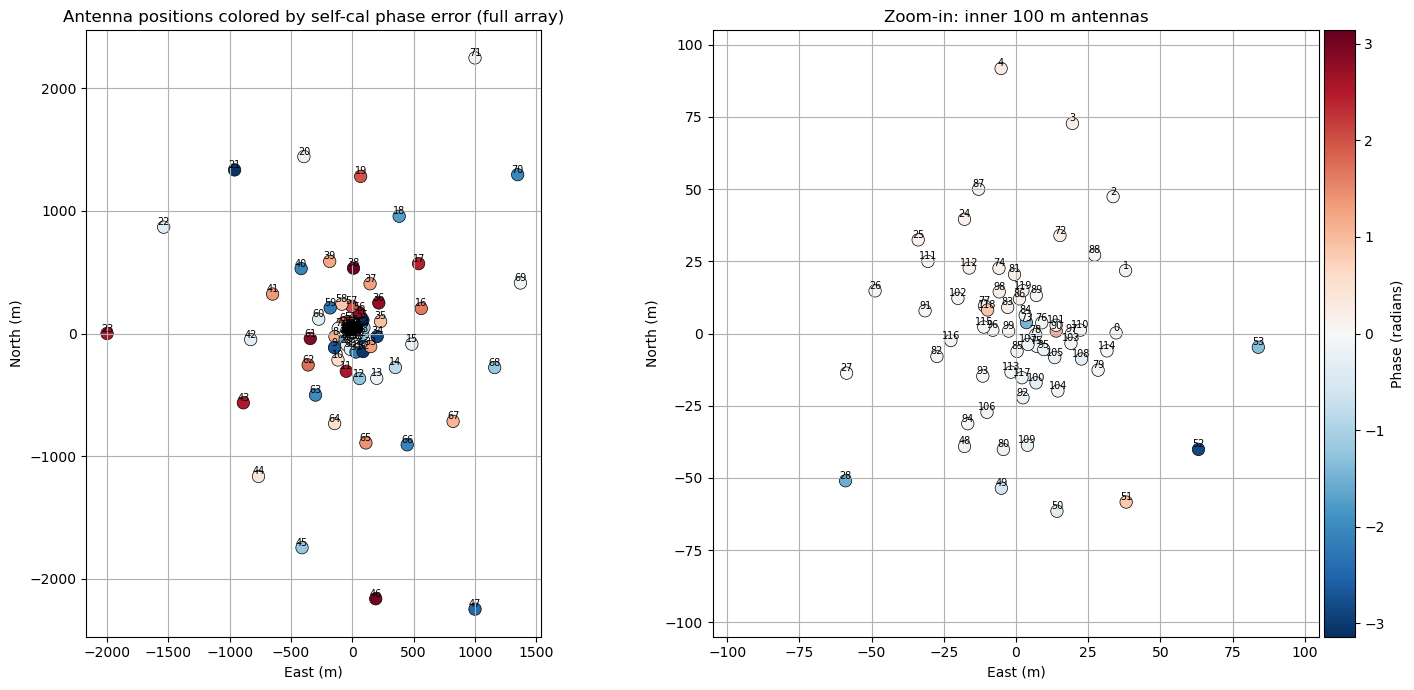

  [applycal] Applying 1 table(s) -> FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_5GHz_20201126T20UT_dur1s_int1s_noise300K.172deg_50pct.corrupted_selfcal_iter0_applied.ms


2026-02-07 17:54:06	WARN	clearcal::calibrater::setvi(bool,bool)	Forcing use of OLD VisibilityIterator.


  [tclean] Shallow clean (niter=100) -> FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_5GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr171.9deg_amperr50pct_itersc_selfcal_iter0


2026-02-07 17:54:07	WARN	SynthesisParamsImage::buildCoordinateSystem (file src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2501)	Did not get the position of FASR from data repository
2026-02-07 17:54:07	WARN	SynthesisParamsImage::buildCoordinateSystem (file src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2501)	Please contact CASA to add it to the repository.
2026-02-07 17:54:07	WARN	SynthesisParamsImage::buildCoordinateSystem (file src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2501)	Using first antenna position as refence 


  Model updated to: FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_5GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr171.9deg_amperr50pct_itersc_selfcal_iter0.image

Self-cal round 1: uvrange=<12klambda, calmode=ap, niter=300
  [ft] Filling MODEL column of FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_5GHz_20201126T20UT_dur1s_int1s_noise300K.172deg_50pct.corrupted_selfcal.ms with FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_5GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr171.9deg_amperr50pct_itersc_selfcal_iter0.image
  [gaincal] Solving round 1 -> FASR-A/caltbs/selfcal_round1.ap
            on-the-fly gaintable: ['FASR-A/caltbs/selfcal_round0.p']
4 of 118 solutions flagged due to SNR < 3 in spw=0 at 2020/11/26/19:25:52.7
  --- Round FASR-A/caltbs/selfcal_combined_round1.ap diagnostics (FASR-A/caltbs/selfcal_round1.ap) ---
      Antennas with solutions: 59/120
      Flagged antennas (61): [5, 6, 7, 8, 9, 10, 11, 

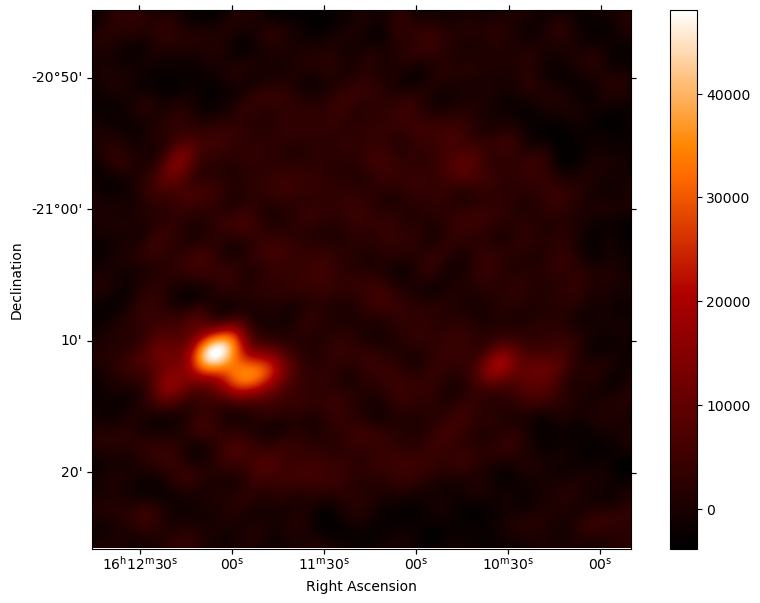

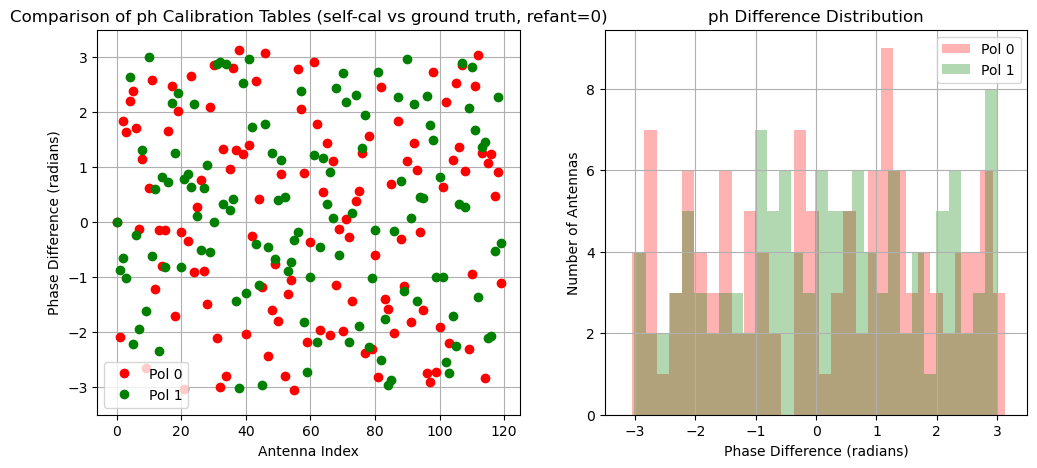

      RMS phase error vs truth (Pol0/Pol1): 102.09 / 95.63 deg


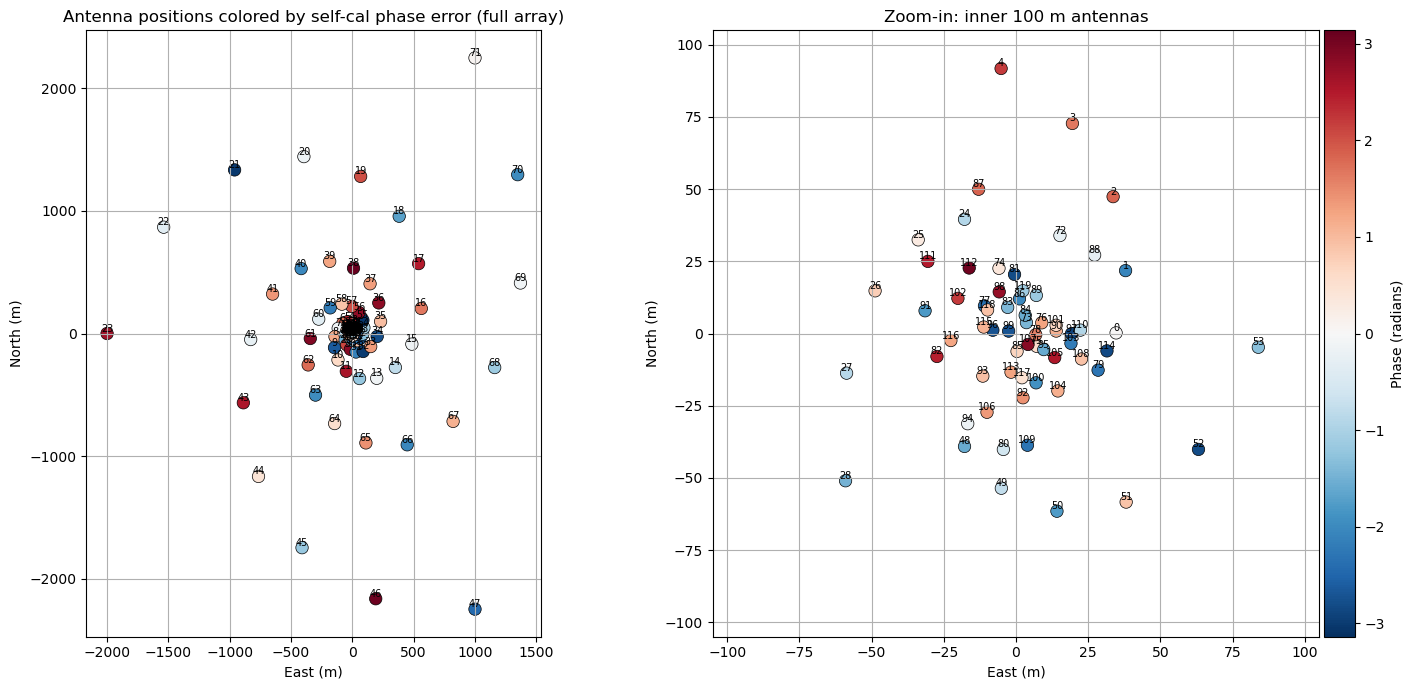

  [applycal] Applying 2 table(s) -> FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_5GHz_20201126T20UT_dur1s_int1s_noise300K.172deg_50pct.corrupted_selfcal_iter1_applied.ms


2026-02-07 17:54:19	WARN	clearcal::calibrater::setvi(bool,bool)	Forcing use of OLD VisibilityIterator.


  [tclean] Shallow clean (niter=300) -> FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_5GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr171.9deg_amperr50pct_itersc_selfcal_iter1


2026-02-07 17:54:19	WARN	SynthesisParamsImage::buildCoordinateSystem (file src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2501)	Did not get the position of FASR from data repository
2026-02-07 17:54:19	WARN	SynthesisParamsImage::buildCoordinateSystem (file src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2501)	Please contact CASA to add it to the repository.
2026-02-07 17:54:19	WARN	SynthesisParamsImage::buildCoordinateSystem (file src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2501)	Using first antenna position as refence 


  Model updated to: FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_5GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr171.9deg_amperr50pct_itersc_selfcal_iter1.image

Building combined calibration table from all rounds
  Combined calibration table: FASR-A/caltbs/selfcal_combined.ap

--- Final comparison: combined selfcal vs ground truth (phase) ---


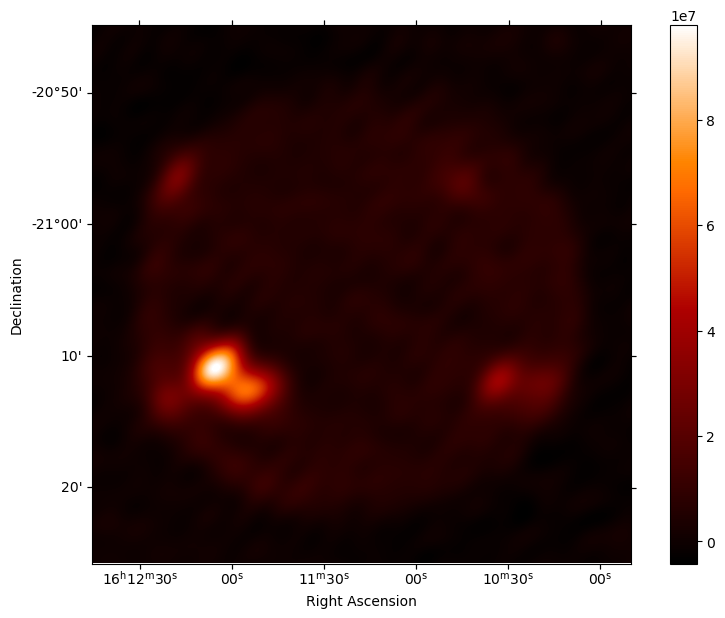

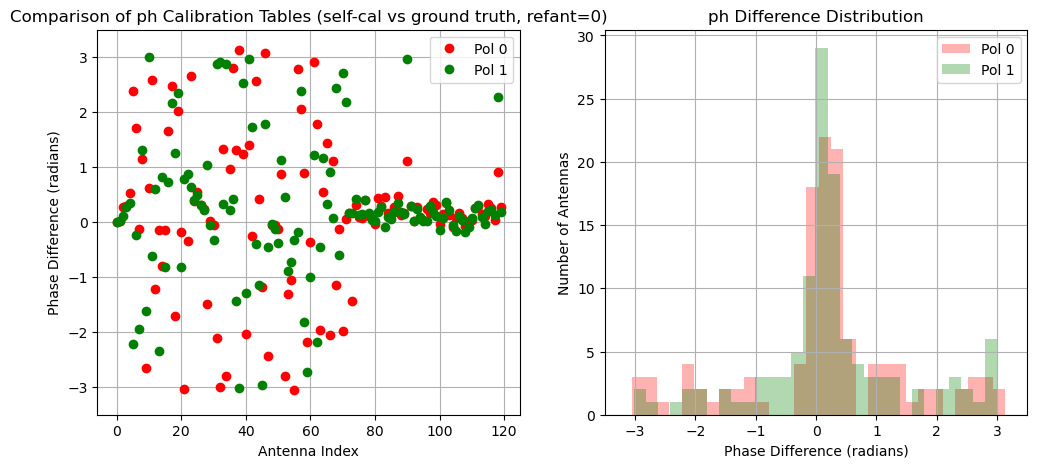

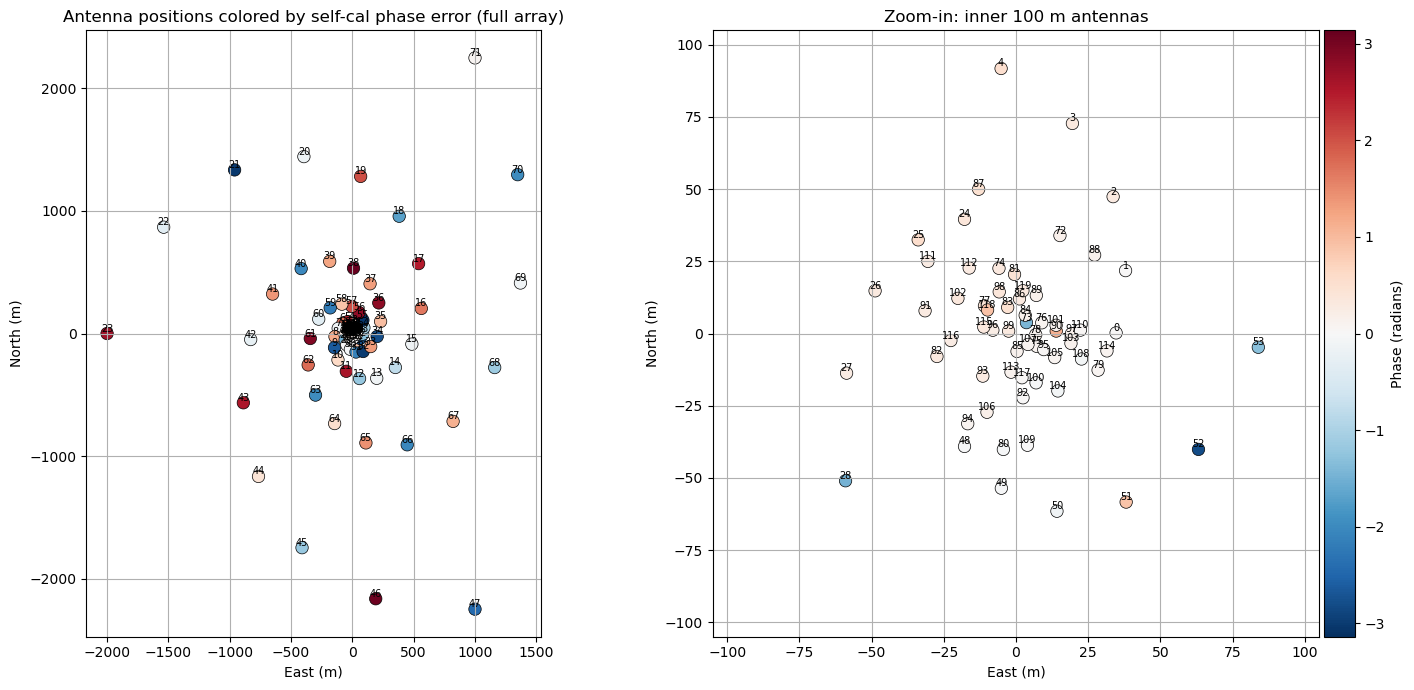

--- Final comparison: combined selfcal vs ground truth (amplitude) ---


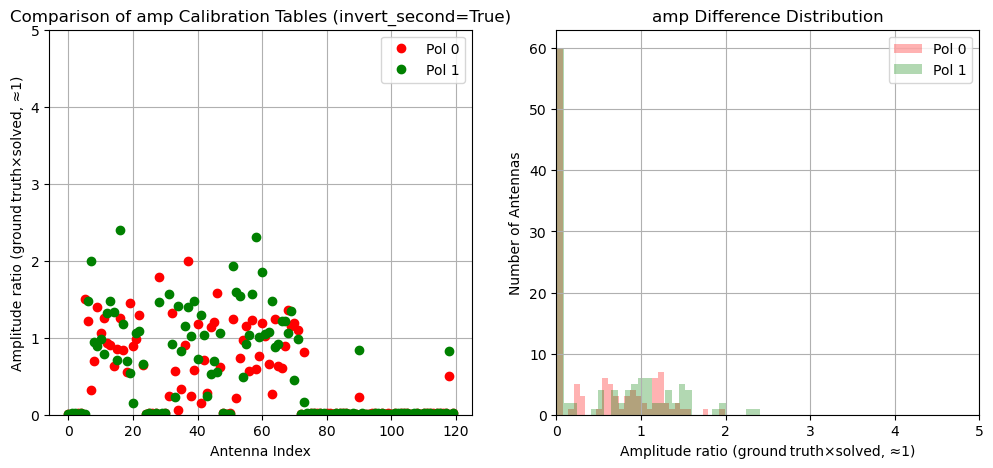


Applying all 2 tables to produce final corrected MS: FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_5GHz_20201126T20UT_dur1s_int1s_noise300K.172deg_50pct.corrupted_selfcal_selfcal_final.ms


2026-02-07 17:54:42	WARN	clearcal::calibrater::setvi(bool,bool)	Forcing use of OLD VisibilityIterator.



*** Iterative self-calibration complete ***
  Rounds completed:      2
  Calibration tables:    ['FASR-A/caltbs/selfcal_round0.p', 'FASR-A/caltbs/selfcal_round1.ap']
  Combined table:        FASR-A/caltbs/selfcal_combined.ap
  Final model image:     FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_5GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr171.9deg_amperr50pct_itersc_selfcal_iter1.image
  Final corrected MS:    FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_5GHz_20201126T20UT_dur1s_int1s_noise300K.172deg_50pct.corrupted_selfcal_selfcal_final.ms
'iterative_selfcal' completed at 2026-02-07 12:54:42; runtime: 38.79 seconds


In [82]:
# --- Iterative baseline-bootstrapping self-calibration ---
# Progressively extend uvrange: inner core -> mid-range -> nearly all -> all baselines.
# Inner antenna solutions act as anchors for outer antennas in later rounds.
reload(fss)

# uvrange schedule (tune these for your array / frequency)
#uvrange_steps = ['<10klambda', '<30klambda', '<80klambda', '']
#calmodes      = ['p',          'ap',         'ap',          'ap']
#niter_steps   = [1000,          4000,          6000,           8000]
uvrange_steps = ['<8klambda', '<12klambda']
calmodes      = ['p', 'ap']
niter_steps   = [100, 300]

all_gaintables, combined_caltb, final_model, ms_corrected = fss.iterative_selfcal(
    ms_selfcal=ms_selfcal,
    model_image=imname_init_model,
    config_file=config_file,
    uvrange_steps=uvrange_steps,
    calmodes=calmodes,
    niter_steps=niter_steps,
    imsize=imsize_target,
    cell=cell_target,
    weighting=weighting,
    scales=scale_target,
    deconvolver='multiscale',
    refant='0',
    minblperant=4,
    minsnr=3.0,
    caltbdir=caltbdir,
    imname_base=imname.replace(deconvolver, 'itersc'),
    ground_truth_ph_caltb=gaintable[0],
    ground_truth_amp_caltb=gaintable[1],
    overwrite=True,
)

['FASR-A/caltbs/selfcal_round0.p']


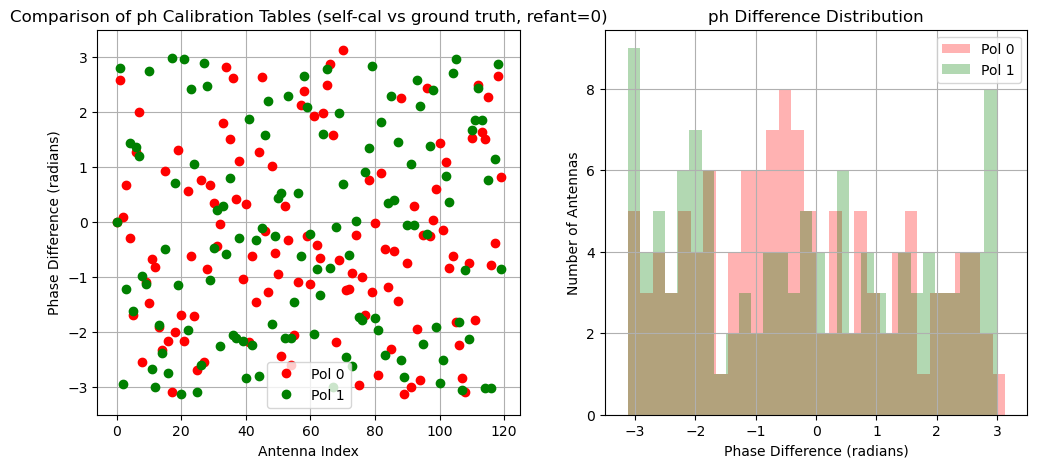

In [15]:
print(all_gaintables)
diff = fss.compare_two_gaintables(gaintable[0], all_gaintables[0], caltype='ph', refant='0', invert_second=True, yrange=[-3.5, 3.5])

Opening calibration table: FASR-A/caltbs/caltb_5GHz_selfcal0.p
Shape of the data in FASR-A/caltbs/caltb_5GHz_selfcal0.p: (2, 1, 120)


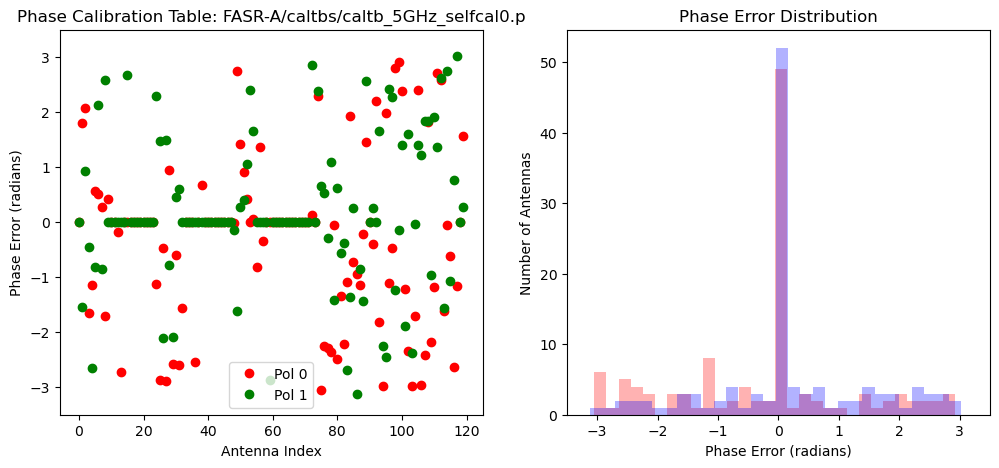

Opening calibration table: FASR-A/caltbs/caltb_FASR_corrupt_172deg.ph
Shape of the data in FASR-A/caltbs/caltb_FASR_corrupt_172deg.ph: (2, 1, 120)


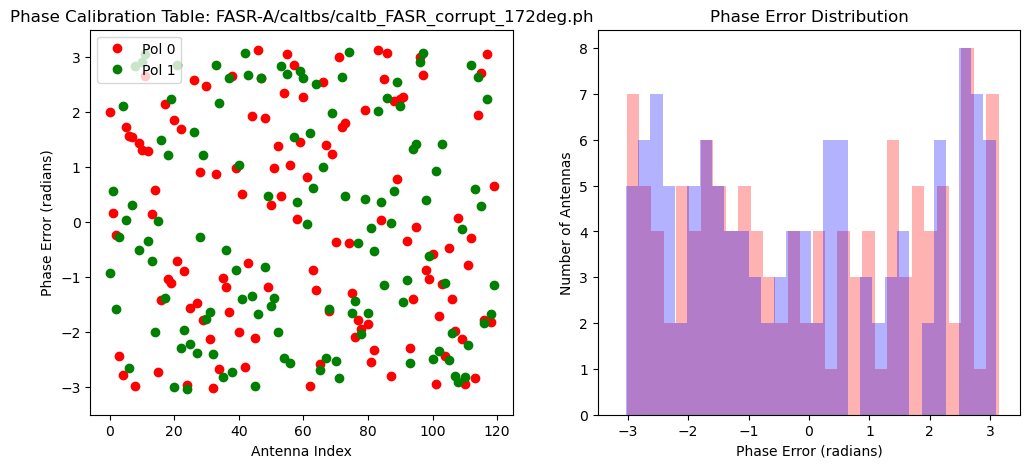

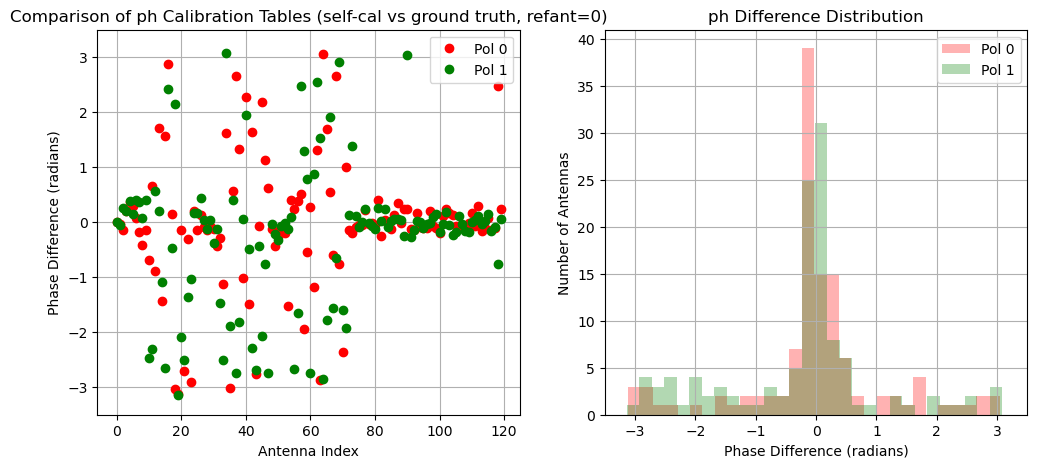

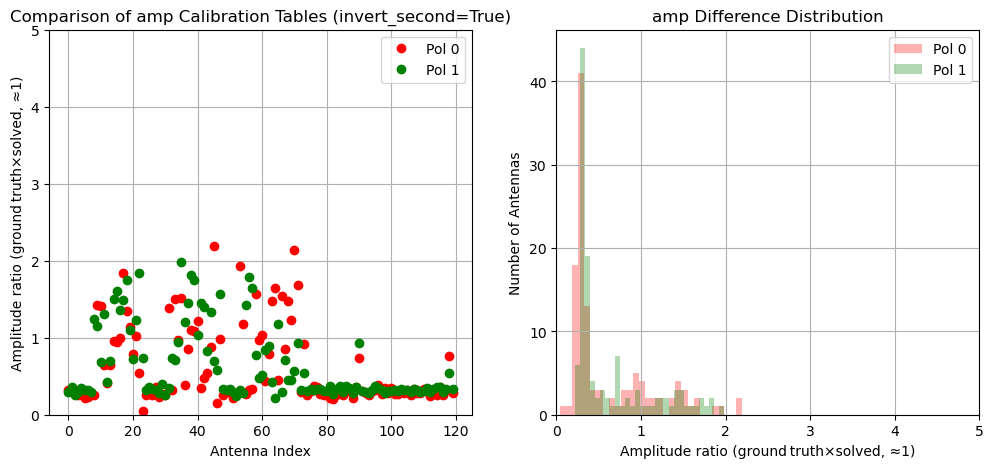

Comparing initial calibration table FASR-A/caltbs/caltb_FASR_corrupt_172deg.ph with self-calibration table 2 FASR-A/caltbs/caltb_5GHz_selfcal0.p:


In [92]:
# -- Post-selfcal: make a final clean image from the corrected MS --
imname_final = imname.replace(deconvolver, 'itersc_final')
overwrite_final = True
if overwrite_final:
    for ext in ['.image', '.model', '.residual', '.psf', '.flux',
                '.mask', '.pb', '.image.pbcor', '.sumwt']:
        p = f'{imname_final}{ext}'
        if os.path.exists(p):
            os.system(f'rm -rf {p}')
if not os.path.exists(f'{imname_final}.image'):
    tclean(vis=ms_corrected,
           imagename=imname_final,
           imsize=imsize_target,
           cell=cell_target,
           weighting=weighting,
           deconvolver='multiscale',
           scales=scale_target,
           gain=0.2, cycleniter=200, minpsffraction=0.1, pblimit=0.01,
           niter=5000,
           savemodel='none',
           interactive=False)
    print('Final clean image created:', imname_final)
    for suffix in ['.model', '.residual', '.psf', '.flux',
                   '.mask', '.pb', '.image.pbcor', '.sumwt']:
        p = f'{imname_final}{suffix}'
        if os.path.exists(p):
            os.system(f'rm -rf {p}')
fss.plot_casa_image(imname_final + '.image', cmap='hinodexrt')

In [77]:
# (Replaced by iterative_selfcal)

In [ ]:
# (Replaced by iterative_selfcal)

In [71]:
# (Replaced by iterative_selfcal)

In [73]:
# (Replaced by iterative_selfcal)

In [134]:
# (Replaced by iterative_selfcal)